### Look at first run results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tqdm
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import region_names, deg_string, gkg_string, region_points
from nemo_python_git.projects import testing, evaluation, overshoots
from nemo_python_git.plots import timeseries_by_region, timeseries_plot, circumpolar_plot, finished_plot
from nemo_python_git.plot_utils import set_colours
from matplotlib.lines import Line2D
import glob
import cmocean

In [2]:
import datetime as dt 
import seaborn as sns

In [5]:
run_folder1 = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4/'
run_folder2 = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4_cont/'

spinup_ds = xr.open_dataset(f'{run_folder1}timeseries.nc')
real_ds   = xr.open_dataset(f'{run_folder2}timeseries.nc')

In [8]:
var_names    = ['bwtemp', 'bwsalt', 'cavity_temp', 'cavity_salt', 'shelf_temp', 'shelf_salt', 'draft']
regions = ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']
colours      = ['IndianRed', 'SandyBrown', 'LightGreen', 'MediumTurquoise', 'Plum', 'Pink', 'gray']

In [114]:
from nemo_python_git.constants import region_names

In [129]:
var = 'cavity_temp'
title = 'Volume-averaged temperature for cavities'

Text(0, 0.5, 'Volume-averaged temperature for cavities ($^{\\circ}$C)')

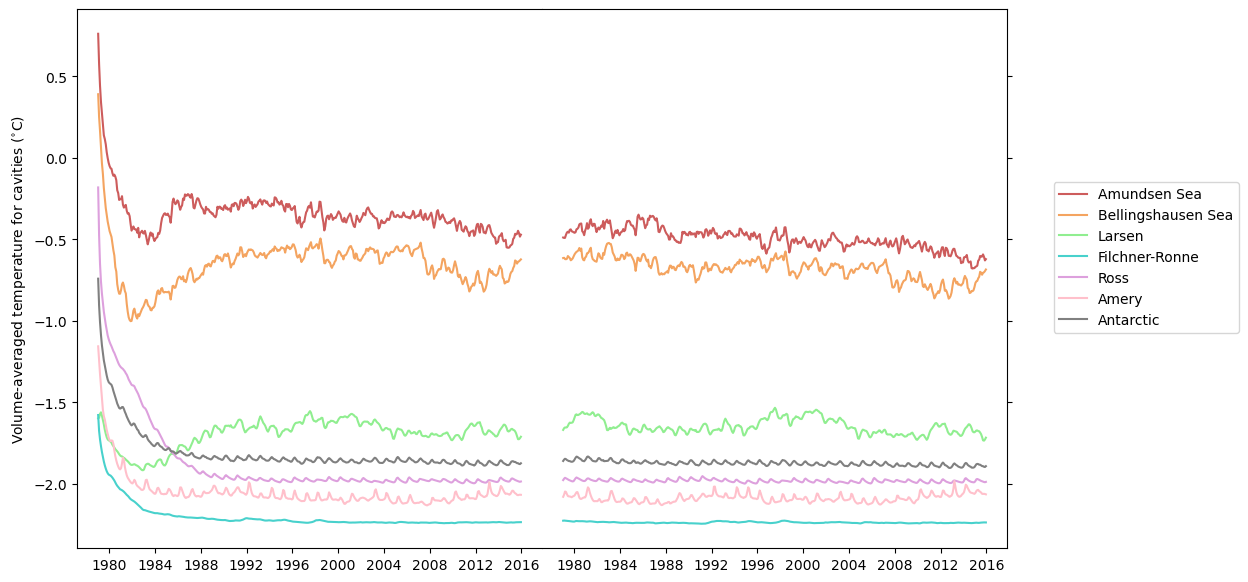

In [130]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,7), sharey=True, facecolor='w')
plt.subplots_adjust(wspace=0)

# plot the same data on both axes
for region, colour in zip(regions, colours):
    ax.plot(spinup_ds['time_centered'], spinup_ds[f'{region}_{var}'], label=region_names[region], c=colour)
    ax2.plot(real_ds['time_centered'], real_ds[f'{region}_{var}'], c=colour)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()
ax.legend(loc=(2.1,0.4))
ax.set_ylabel(f"{title} ({spinup_ds[f'{region}_{var}'].units})")

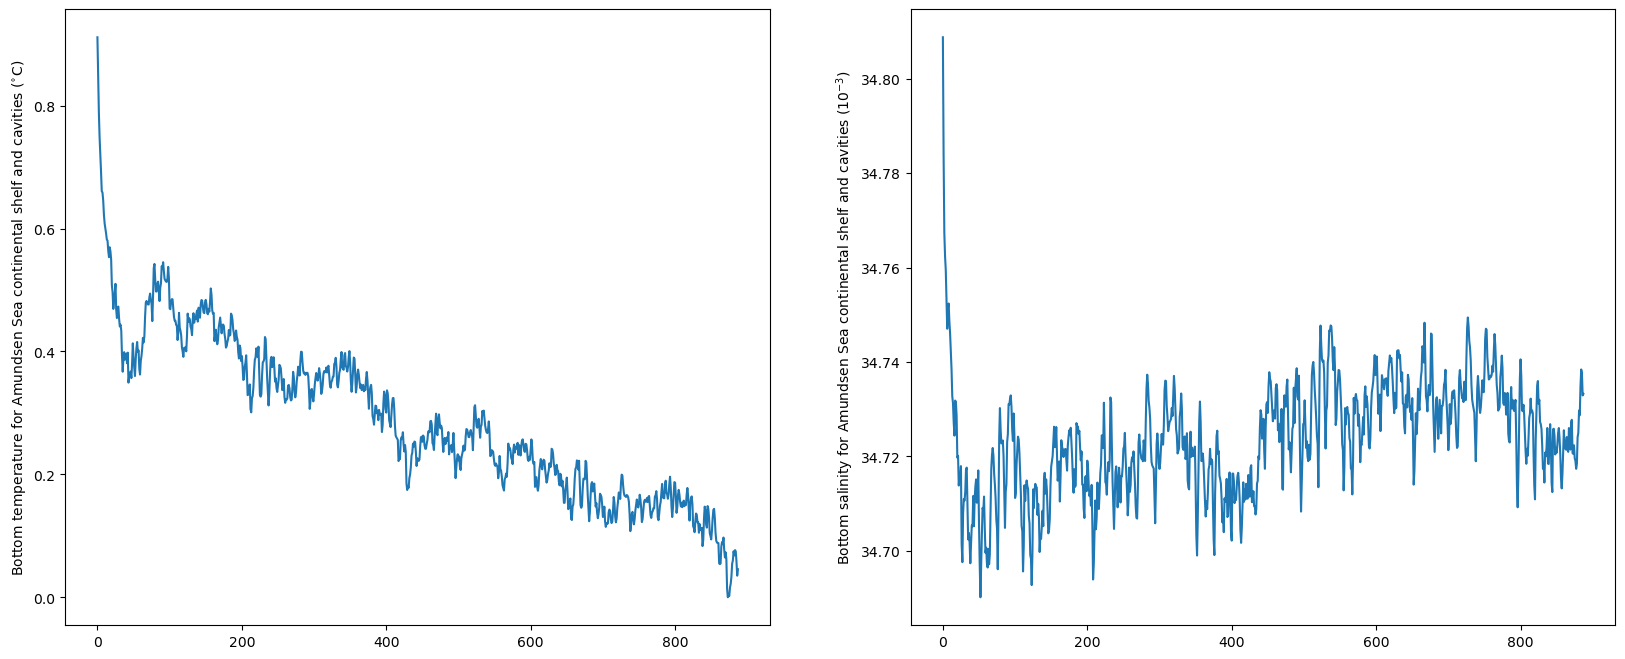

In [86]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_ylabel(f"{spinup_ds['amundsen_sea_bwtemp'].long_name} ({spinup_ds['amundsen_sea_bwtemp'].units})")
ax[0].plot(bwtemp)
# ax[0].set_xticks(x, year_ticks)

ax[1].set_ylabel(f"{spinup_ds['amundsen_sea_bwsalt'].long_name} ({spinup_ds['amundsen_sea_bwsalt'].units})")
ax[1].plot(bwsalt)

In [7]:
from nemo_python_git.constants import region_names
from nemo_python_git.utils import moving_average 

datas = []
labels = []
colours_plot = []
title = None
units = None
for region, colour in zip(regions, colours):
    labels.append(region_names[region])
    labels += [None]*(num_ens-1)
    colours_plot += [colour]*num_ens
    var_full = region+'_'+var_name
    for ds in all_ds:
        datas.append(moving_average(ds[var_full], smooth))
        if title is None:
            long_name = ds[var_full].long_name
            title = long_name.replace(region_names[region]+' ','')
            units = ds[var_full].units

    timeseries_plot(datas, labels=labels, colours=colours_plot, title=title, units=units, fig_name=fig_name, linewidth=linewidth)

<xarray.Dataset>
Dimensions:                         (time_centered: 444)
Coordinates:
  * time_centered                   (time_centered) datetime64[ns] 1979-01-16...
    time_counter                    (time_centered) datetime64[ns] ...
Data variables: (12/49)
    amundsen_sea_bwtemp             (time_centered) float64 ...
    amundsen_sea_bwsalt             (time_centered) float64 ...
    amundsen_sea_cavity_temp        (time_centered) float64 ...
    amundsen_sea_cavity_salt        (time_centered) float64 ...
    amundsen_sea_shelf_temp         (time_centered) float64 ...
    amundsen_sea_shelf_salt         (time_centered) float64 ...
    ...                              ...
    all_bwsalt                      (time_centered) float64 ...
    all_cavity_temp                 (time_centered) float64 ...
    all_cavity_salt                 (time_centered) float64 ...
    all_shelf_temp                  (time_centered) float64 ...
    all_shelf_salt                  (time_centered) float64 ...
    all_draft                       (time_centered) float64 ...

Also look at:
- SSH drift in full domain
- T, S thermocline drift

In [3]:
run_folder1 = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4/'
run_folder2 = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4_cont/'
gridT_files = glob.glob(f'{run_folder2}/*grid_T*') #+ glob.glob(f'{run_folder2}/*grid_T*')
SSH_ds  = xr.open_mfdataset(gridT_files) 

In [4]:
mesh_ds = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc')

In [23]:
time = np.repeat(SSH_ds.time_counter.values, SSH_ds.dims['x_grid_T']*SSH_ds.dims['y_grid_T'])
SSH  = SSH_ds.zos.stack(cells=['x_grid_T','y_grid_T']).values.flatten()

timem = np.delete(time,(SSH==0) | (np.isnan(SSH)))
SSHm  = np.delete(SSH, (SSH==0) | (np.isnan(SSH)))
aream = np.delete(ocean_area.values, (SSH==0) | (np.isnan(SSH)))

In [16]:
ocean_area = xr.where(mesh_ds.tmask.isel(time_counter=0, nav_lev=0).values==0, 0, SSH_ds.area_grid_T)
SSH_ave    = ((SSH_ds.zos*ocean_area).sum(dim=('x_grid_T', 'y_grid_T')) / ocean_area.sum(dim=('x_grid_T', 'y_grid_T')))
SSH_max    = SSH_ds.zos.max(dim=('x_grid_T','y_grid_T'))
SSH_min    = SSH_ds.zos.min(dim=('x_grid_T','y_grid_T'))

(-2.0, 0.5)

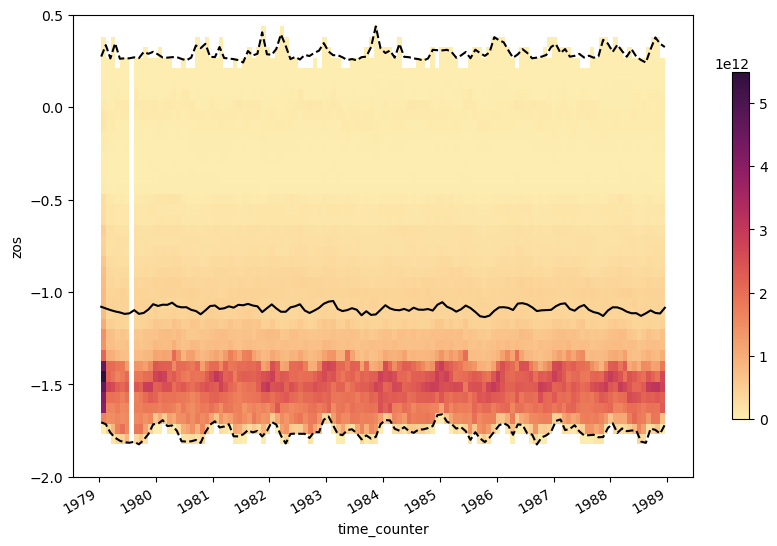

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.histplot(x=timem, y=SSHm, ax=ax, bins=(SSH_ds.dims['time_counter'], 40), weights=aream, \
             cmap=cmocean.cm.matter,cbar=True, cbar_kws=dict(shrink=.75))

SSH_ave.plot(ax=ax, c='k')
ax.set_ylim(-2, 0.5)
# ax.set_xlim(1979,1980)

Create file containing region masks

In [3]:
def create_regions_file(nemo_mesh, option, out_file):

    ds = xr.Dataset(
        coords={'nav_lon':(["y","x"], nemo_mesh.nav_lon.values),
                'nav_lat':(["y","x"], nemo_mesh.nav_lat.values)})
    
    masks={}
    # later should be for name in region_names
    for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
        mask, _, region_name = region_mask(name, nemo_mesh, option=option, return_name=True) 
        masks[name] = mask 
        ds = ds.assign({f'mask_{name}':(["y","x"], masks[name].values)})   
    
    ds.to_netcdf(out_file)
    
    return ds

In [ ]:
create_regions_file(nemo_mesh, 'all'   , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')
create_regions_file(nemo_mesh, 'shelf' , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_shelf.nc')
create_regions_file(nemo_mesh, 'cavity', '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_cavity.nc')

Processing amundsen_sea
Processing bellingshausen_sea
Processing larsen
Processing filchner_ronne
Processing east_antarctica
Processing amery
Processing ross


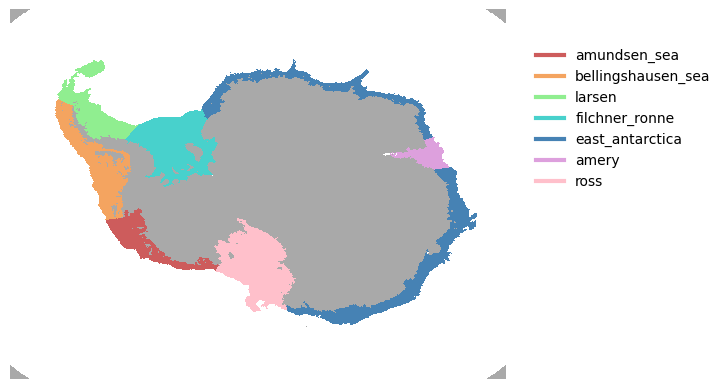

In [2]:
testing.plot_region_map(file_path='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc', 
                        option='all', fig_name=None, halo=False, legend=True)

In [14]:
# load regions file
regions_file = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')

In [15]:
regions   = ['amundsen_sea', 'bellingshausen_sea', 'larsen', 'filchner_ronne', 'amery', 'ross', 'all']
colours   = ['IndianRed', 'SandyBrown', 'LightGreen', 'MediumTurquoise', 'Plum', 'Pink', 'gray']
var_names = ['bwtemp', 'bwsalt', 'cavity_temp', 'cavity_salt', 'shelf_temp', 'shelf_salt', 'draft']

In [16]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4'
nemo_mesh  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc')

# Timeseries of domain average sea surface height

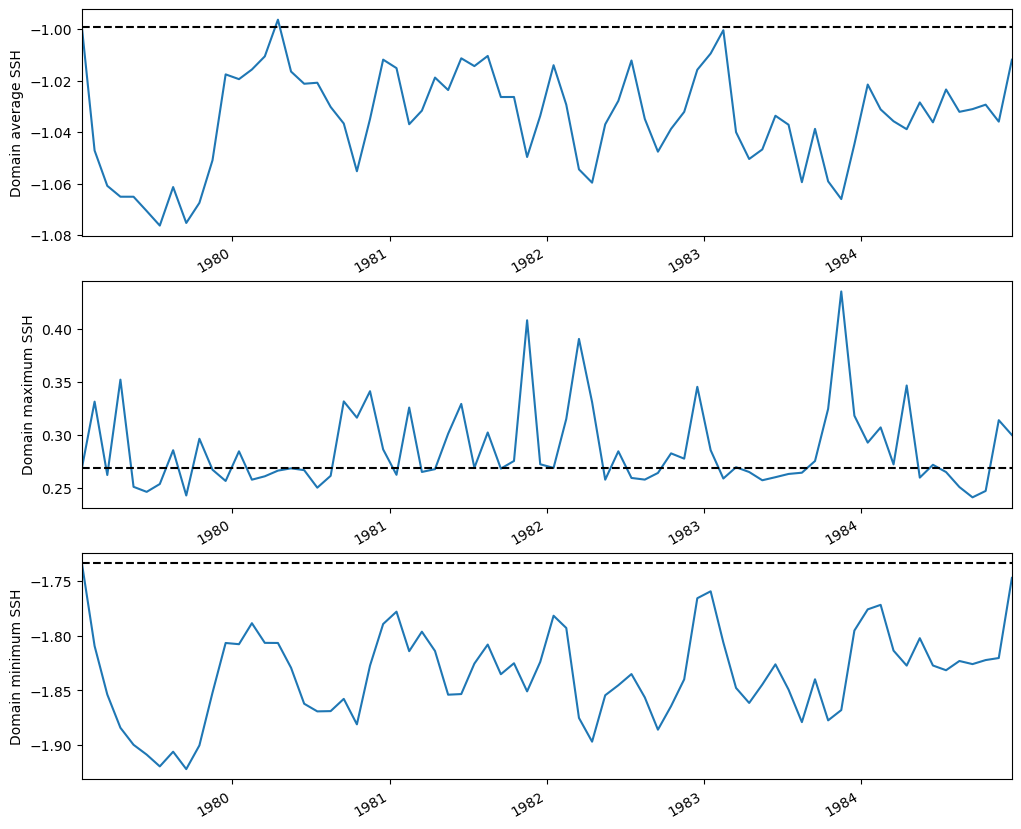

In [70]:
# Load SSH into dataset and calculate domain-wide average, minimum, maximum:
files = glob.glob(f'{run_folder}/*grid_T*')
SSH_ds  = xr.open_mfdataset(files)
SSH_ave = ((SSH_ds.zos*SSH_ds.area_grid_T).sum(dim=('x_grid_T', 'y_grid_T')) / SSH_ds.area_grid_T.sum(dim=('x_grid_T', 'y_grid_T')))
SSH_max = SSH_ds.zos.max(dim=('x_grid_T','y_grid_T'))
SSH_min = SSH_ds.zos.min(dim=('x_grid_T','y_grid_T'))

# Visualize:
fig, ax = plt.subplots(3,1, figsize=(12,10))
SSH_ave.plot(ax=ax[0], xlim=(SSH_ave.time_counter[0], SSH_ave.time_counter[-1]))
SSH_max.plot(ax=ax[1], xlim=(SSH_max.time_counter[0], SSH_max.time_counter[-1]))
SSH_min.plot(ax=ax[2], xlim=(SSH_min.time_counter[0], SSH_min.time_counter[-1]))

# horizontal reference lines:
ax[0].hlines(y=SSH_ave[0], xmin=SSH_ave.time_counter[0], xmax=SSH_ave.time_counter[-1], color='k', linestyle='--')
ax[1].hlines(y=SSH_max[0], xmin=SSH_max.time_counter[0], xmax=SSH_max.time_counter[-1], color='k', linestyle='--')
ax[2].hlines(y=SSH_min[0], xmin=SSH_min.time_counter[0], xmax=SSH_min.time_counter[-1], color='k', linestyle='--')

# labels:
ax[0].set_ylabel('Domain average SSH')
ax[1].set_ylabel('Domain maximum SSH')
ax[2].set_ylabel('Domain minimum SSH')
for axis in ax.ravel():
    axis.set_xlabel('')

In [17]:
i=0
for year in tqdm.tqdm(range(1979,1985)):
        with xr.open_dataset(f'{run_folder}/eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc') as file:
            total_area = file.area_grid_T.sum()
            area_weighted_SSH = (file.zos*file.area_grid_T).sum(dim=('x_grid_T', 'y_grid_T')) / total_area
            if i==0:
                SSH_min   = file.zos.min(dim=('x_grid_T','y_grid_T')).values
                SSH_max   = file.zos.max(dim=('x_grid_T','y_grid_T')).values
                SSH_ave   = area_weighted_SSH.values
                SSH_years = file.time_counter.values

            else:
                SSH_min   = np.append(SSH_min, file.zos.min(dim=('x_grid_T','y_grid_T')).values)
                SSH_max   = np.append(SSH_max, file.zos.max(dim=('x_grid_T','y_grid_T')).values)
                SSH_ave   = np.append(SSH_ave, area_weighted_SSH.values)
                SSH_years = np.append(SSH_years, file.time_counter.values)
            i+=1

100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


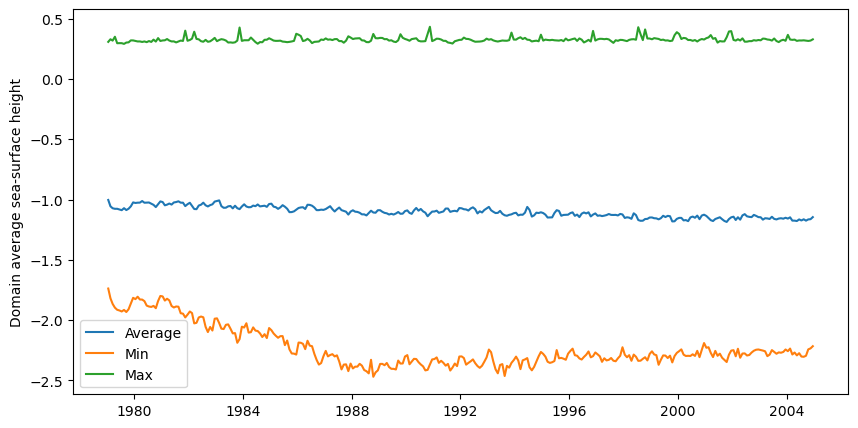

In [62]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(SSH_years, SSH_ave, label='Average')
ax.plot(SSH_years, SSH_min, label='Min')
ax.plot(SSH_years, SSH_max, label='Max')
ax.set_ylabel('Domain average sea-surface height')

ax.legend()

Text(0, 0.5, 'Domain average sea-surface height')

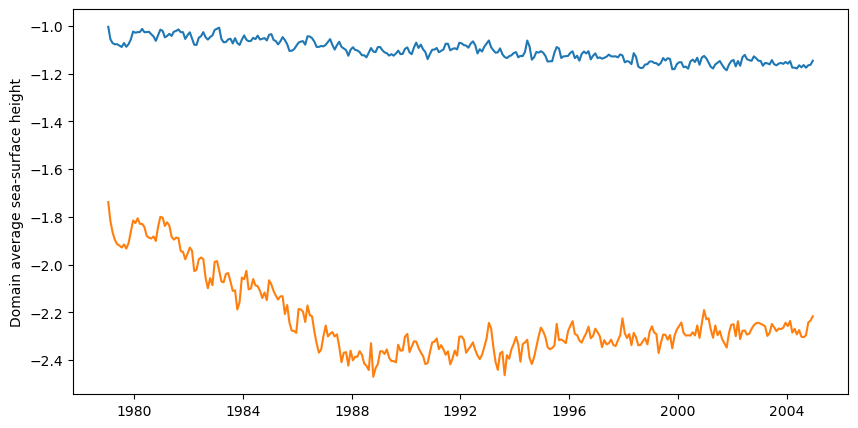

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(SSH_years, SSH_ave, label='Average')
ax.plot(SSH_years, SSH_min, label='Min')
ax.set_ylabel('Domain average sea-surface height')

Text(0, 0.5, 'Domain average sea-surface height')

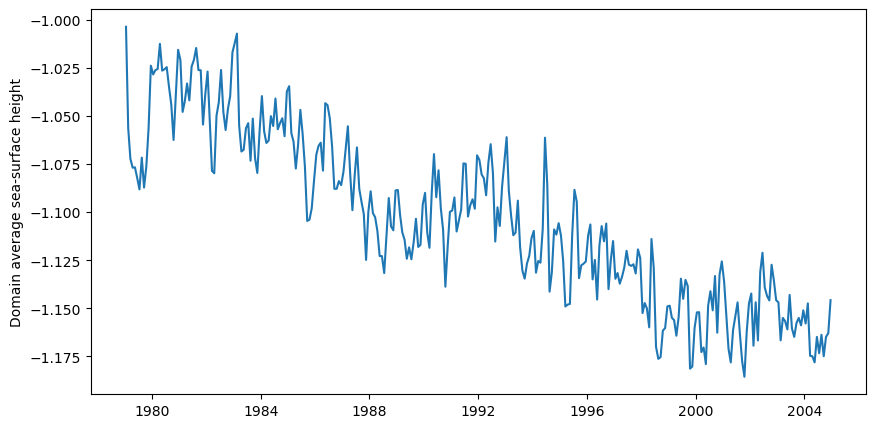

In [64]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(SSH_years, SSH_ave, label='Average')
ax.set_ylabel('Domain average sea-surface height')

Text(0, 0.5, 'Sea surface height')

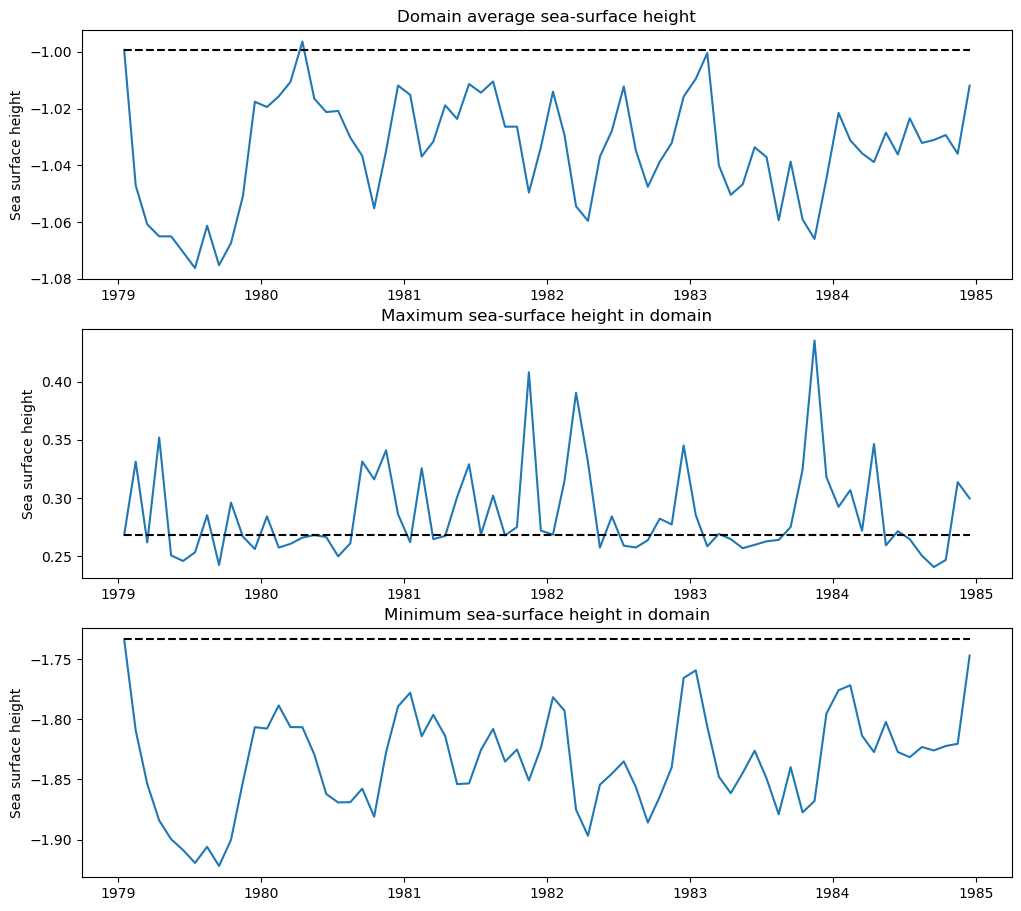

In [27]:
fig, ax = plt.subplots(3,1, figsize=(12,11))
ax[0].set_title('Domain average sea-surface height')
ax[0].plot(SSH_years, SSH_ave)
ax[0].plot([SSH_years[0], SSH_years[-1]], [SSH_ave[0], SSH_ave[0]], '--k')
ax[0].set_ylabel('Sea surface height')

ax[1].set_title('Maximum sea-surface height in domain')
ax[1].plot(SSH_years, SSH_max)
ax[1].plot([SSH_years[0], SSH_years[-1]], [SSH_max[0], SSH_max[0]], '--k')
ax[1].set_ylabel('Sea surface height')

ax[2].set_title('Minimum sea-surface height in domain')
ax[2].plot(SSH_years, SSH_min)
ax[2].plot([SSH_years[0], SSH_years[-1]], [SSH_min[0], SSH_min[0]], '--k')
ax[2].set_ylabel('Sea surface height')

# Timeseries by region

Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-bwtemp.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-bwsalt.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-cavity_temp.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-cavity_salt.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-shelf_temp.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-shelf_salt.jpg
Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2/timeseries-draft.jpg


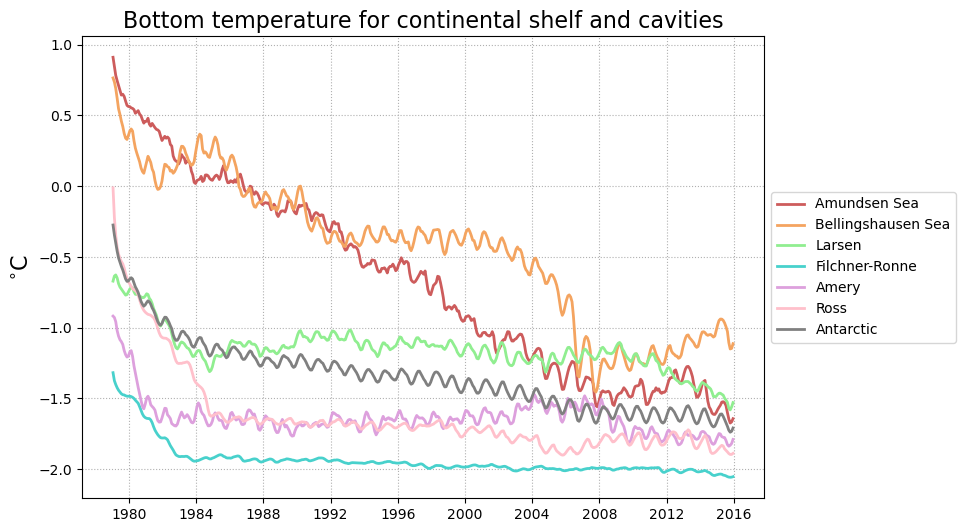

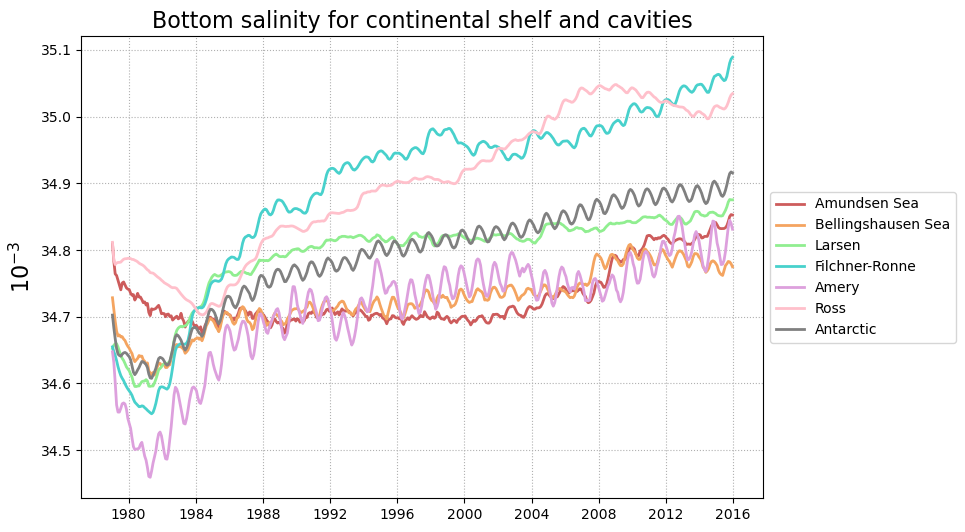

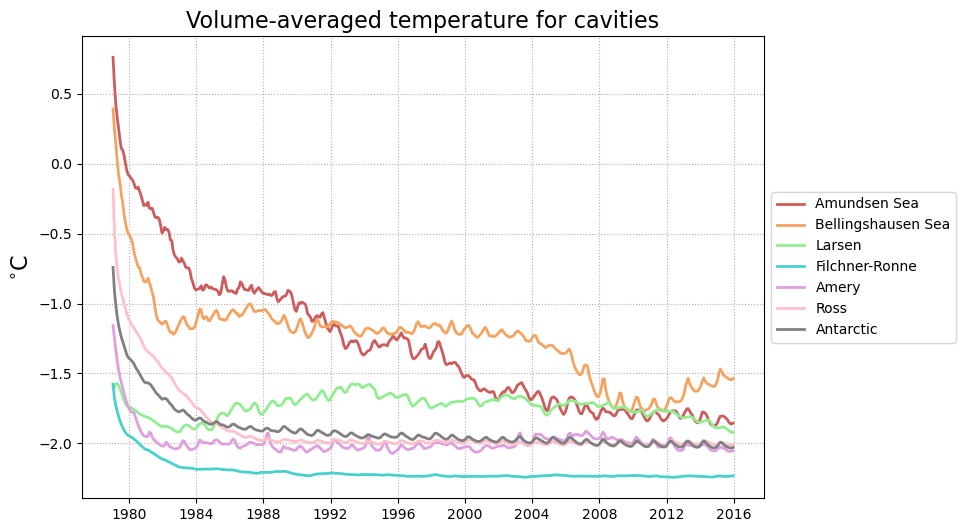

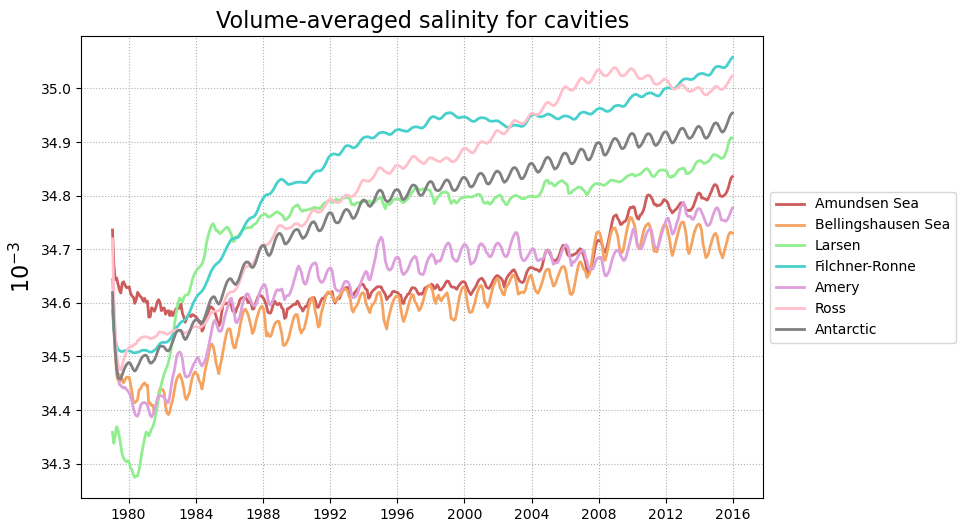

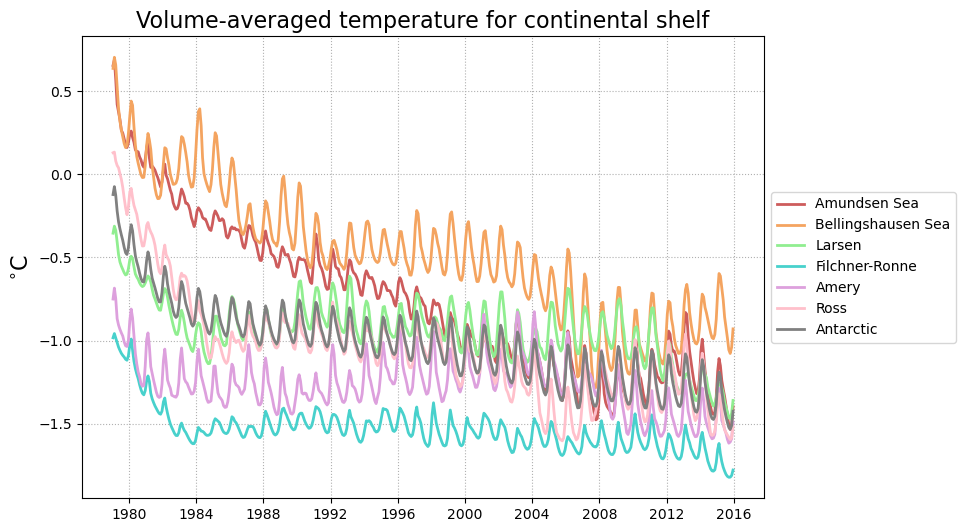

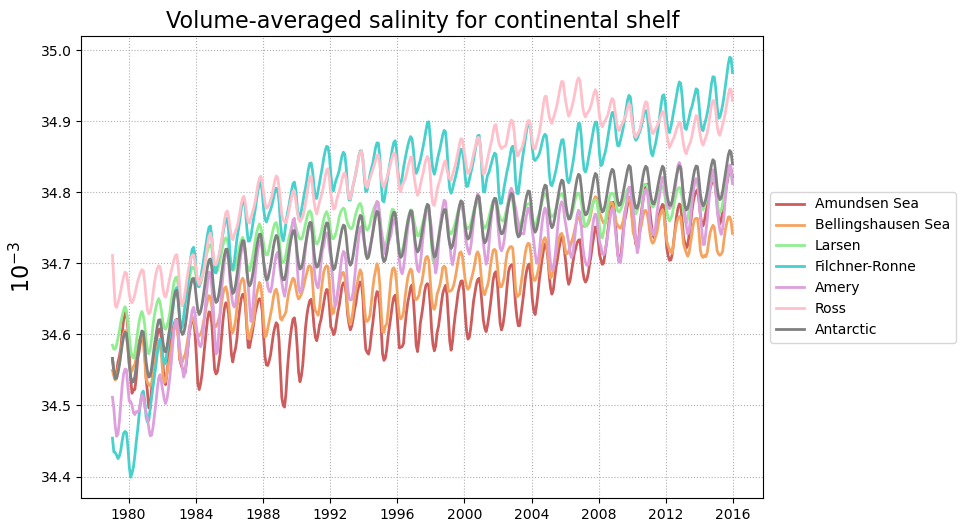

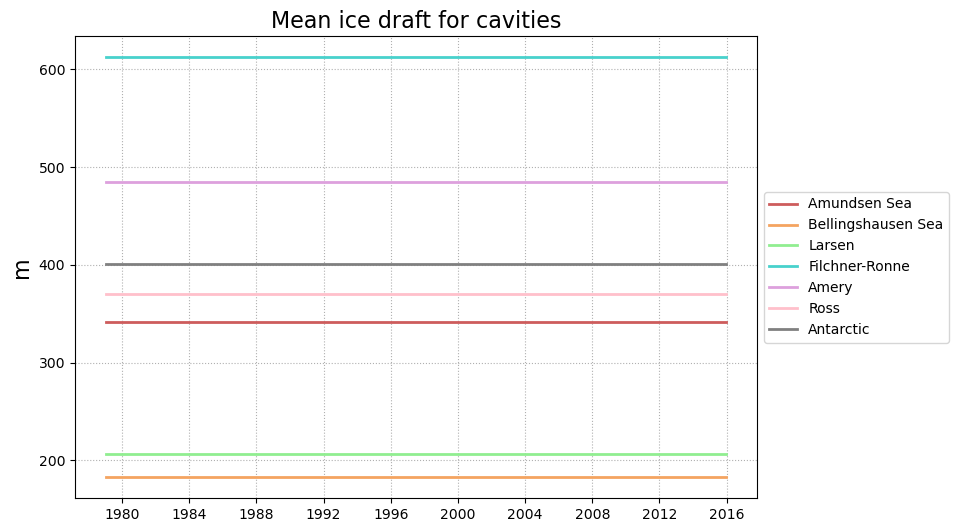

In [9]:
for var in var_names:
    timeseries_by_region(var, f'{run_folder}',
                         regions=regions, colours=colours, timeseries_file='timeseries.nc', smooth=0, 
                         fig_name=f'{run_folder}/timeseries-{var}.jpg', 
                         linewidth=2)

# Hovmoeller plots

In [90]:
def calc_hovmoeller(var, region, run_folder=run_folder, nemo_mesh=nemo_mesh):
    i=0
    nemo_mesh_subset = nemo_mesh.rename({'x':'x_grid_T','y':'y_grid_T','nav_lev':'deptht'}).isel(x_grid_T=region['x'], y_grid_T=region['y'])
    for year in tqdm.tqdm(range(1979,2005)):
        with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').isel(x_grid_T=region['x'], y_grid_T=region['y']) as ds:
            var_ocean  = xr.where(nemo_mesh_subset.tmask.isel(time_counter=0)==0, np.nan, ds[var]) 
            area_ocean = xr.where(nemo_mesh_subset.tmask.isel(time_counter=0)==0, np.nan, ds['area_grid_T']) 
            var_ds     = (var_ocean*area_ocean).sum(dim=['x_grid_T','y_grid_T'])/(area_ocean.sum(dim=['x_grid_T','y_grid_T']))
            if i==0:
                convect_ts = var_ds
            else:
                convect_ts = xr.concat([convect_ts, var_ds], dim='time_counter')
        
        i+=1
    return convect_ts

In [91]:
def hovmoeller_plot(thetao, salt, title=None, fig_size=(15,5), return_fig=False, fig_name=None, ylim=(5500,0), dpi=None, tlim=(-1.5,0.8),
                    slim=(34.8, 34.86)):

    fig, ax = plt.subplots(1,2, figsize=fig_size)
    # cm1 = ax[0].pcolormesh(thetao.time_centered, thetao.deptht, thetao, rasterized=True, cmap=cmocean.cm.thermal, vmin=-1, vmax=1)
    # cm2 = ax[1].pcolormesh(salt.time_centered, salt.deptht, salt, rasterized=True, cmap=cmocean.cm.haline, vmin=34.8, vmax=34.87)
    cm1 = ax[0].pcolormesh(thetao.time_centered, thetao.deptht, thetao, rasterized=True, cmap=cmocean.cm.thermal, vmin=tlim[0], vmax=tlim[1])
    cm2 = ax[1].pcolormesh(salt.time_centered, salt.deptht, salt, rasterized=True, cmap=cmocean.cm.haline, vmin=slim[0], vmax=slim[1])
    fig.colorbar(cm1, ax=ax[0], label='Temperature', extend='both')
    fig.colorbar(cm2, ax=ax[1], label='Salinity', extend='both')
    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.set_ylabel('Depth (m)')
        axis.set_ylim(ylim[0],ylim[1])

    # if title is not None:
    #     fig.suptitle(title)
    # if fig_name is not None:
    #     finished_plot(fig, fig_name=fig_name, dpi=dpi)
    if return_fig:
        return fig, ax
    else:
        return

In [78]:
# x axis--> time
# y axis--> depth
# location: somewhere where deep convection occurs --> Weddell Sea and also check Ross Gyre region (1989, 1991, 2004, 2006)
# ts.amundsen_sea_bwtemp
weddell_convect = {'x':slice(930,1150), 'y':slice(295,360)}
ross_convect    = {'x':slice(450,580),  'y':slice(220,300)}

Look at convection regions

In [120]:
run_folderE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test2'
run_folderJ = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/JRA55_test2'

In [121]:
gridT_files = glob.glob(f'{run_folderE}/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files)

In [123]:
ds = xr.open_dataset(gridT_files[0])

In [124]:
ds

<xarray.Dataset>
Dimensions:                (y_grid_T: 453, x_grid_T: 1440, nvertex_grid_T: 4,
                            deptht: 121, axis_nbounds: 2, time_counter: 12,
                            y_grid_T_inner: 453, x_grid_T_inner: 1440)
Coordinates:
    nav_lat_grid_T         (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T         (y_grid_T, x_grid_T) float32 ...
  * deptht                 (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_centered          (time_counter) datetime64[ns] ...
  * time_counter           (time_counter) datetime64[ns] 1979-01-16T12:00:00 ...
Dimensions without coordinates: y_grid_T, x_grid_T, nvertex_grid_T,
                                axis_nbounds, y_grid_T_inner, x_grid_T_inner
Data variables: (12/15)
    bounds_nav_lon_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    bounds_nav_lat_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    area_grid_T            (y_grid_T, x_grid_T) float32 ...
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    time_centered_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds    (time_counter, axis_nbounds) datetime64[ns] ...
    ...                     ...
    zos                    (time_counter, y_grid_T, x_grid_T) float32 ...
    mldr10_1               (time_counter, y_grid_T, x_grid_T) float32 ...
    sbt                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sbs                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sosst                  (time_counter, y_grid_T, x_grid_T) float32 ...
    sosss                  (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    name:         eANT025.L121_1m_19790101_19791231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Mar-06 15:23:42 GMT
    uuid:         e23523d6-fa3d-4648-b1f2-cd37aab6fbc9

In [ ]:
    img = circumpolar_plot(data_plot[n][var_plot[v]], nemo, ax=ax, masked=True, make_cbar=False, 

File "/home/users/birgal/nemo_python_git/plots.py", line 76, in circumpolar_plot
    lon_edges = cfxr.bounds_to_vertices(grid['bounds_lon'], 'nvertex')
File "/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/cf_xarray/helpers.py", line 70, in bounds_to_vertices
ValueError: Bounds format not understood. Got ('time_counter', 'y', 'x', 'nvertex') with shape (84, 453, 1440, 4).

In [133]:
gridT_files = glob.glob(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files)

In [134]:
nemo = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                              'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                              'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                              'nvertex_grid_T':'nvertex'})

In [135]:
nemo_plot = xr.Dataset({'temp':nemo['sbt'], 'salt':nemo['sbs']}).mean(dim='time_counter')

In [136]:
nemo_plot

<xarray.Dataset>
Dimensions:  (y_grid_T_inner: 453, x_grid_T_inner: 1440)
Dimensions without coordinates: y_grid_T_inner, x_grid_T_inner
Data variables:
    temp     (y_grid_T_inner, x_grid_T_inner) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    salt     (y_grid_T_inner, x_grid_T_inner) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>

In [10]:
thetao_wedE = calc_hovmoeller('thetao', weddell_convect, run_folder=f'{run_folderE}/', nemo_mesh=nemo_mesh)
salt_wedE   = calc_hovmoeller('so', weddell_convect, run_folder=f'{run_folderE}/', nemo_mesh=nemo_mesh)

thetao_wedJ = calc_hovmoeller('thetao', weddell_convect, run_folder=f'{run_folderJ}/', nemo_mesh=nemo_mesh)
salt_wedJ   = calc_hovmoeller('so', weddell_convect, run_folder=f'{run_folderJ}/', nemo_mesh=nemo_mesh)

100%|██████████| 26/26 [06:13<00:00, 14.35s/it]


Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test2/hovmoeller-TS-weddell.jpg


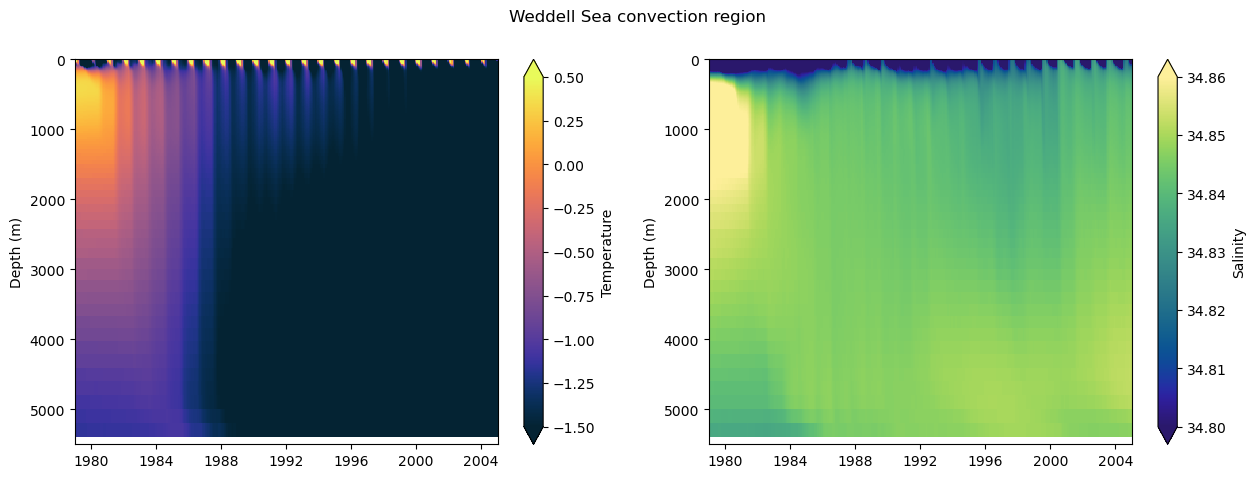

In [70]:
hovmoeller_plot(thetao_wed, salt_wed, title='Weddell Sea convection region', ylim=(5500,0), tlim=(-1.5, 0.5), slim=(34.8, 34.86),
                fig_name=f'{run_folder}/hovmoeller-TS-weddell.jpg')

Saving /gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test2/hovmoeller-TS-ross.jpg


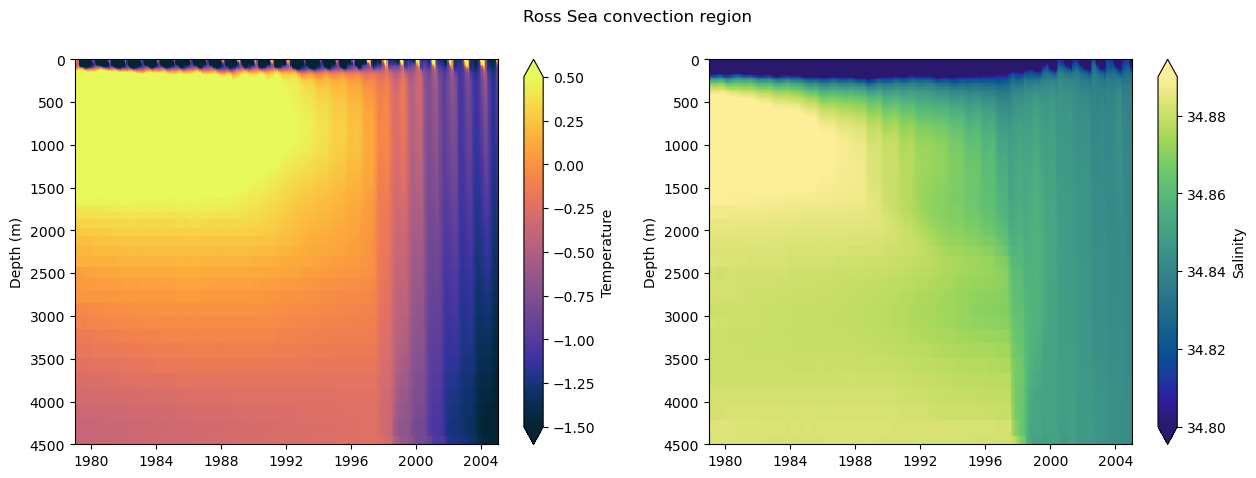

In [72]:
hovmoeller_plot(thetao_ross, salt_ross, title='Ross Sea convection region', ylim=(4500,0), tlim=(-1.5, 0.5), slim=(34.8, 34.89),
                fig_name=f'{run_folder}/hovmoeller-TS-ross.jpg')

# T-S diagrams

For TS diagrams, have a look at this one: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007RG000250

Check drift in near-bottom temperature and salinity by region:

In [9]:
region = weddell_convect
nemo_mesh_subset = nemo_mesh.rename({'x':'x_grid_T','y':'y_grid_T','nav_lev':'deptht'}).isel(x_grid_T=region['x'], y_grid_T=region['y'])

for year in range(1996,2015):
    data   = xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').isel(x_grid_T=region['x'], y_grid_T=region['y'])
    T = xr.where(nemo_mesh_subset.tmask.isel(time_counter=0)==0, np.nan, data.thetao)
    S = xr.where(nemo_mesh_subset.tmask.isel(time_counter=0)==0, np.nan, data.so)
    for month in range(1,13):
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        # sns.kdeplot(x=S.values.flatten(),y=T.values.flatten())
        sns.histplot(x=S.isel(time_counter=month-1).values.flatten(),
                     y=T.isel(time_counter=month-1).values.flatten(), ax=ax, bins=1000)
        ax.set_xlim(34.0,34.9)
        ax.set_ylim(-2.0, 1.5)
        ax.set_xlabel('Absolute Salinity')
        ax.set_ylabel('Conservative Temperature')
        ax.set_title(f'Weddell Sea convection region {year}-{month:02}')
        fig.savefig(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/temp/TS-weddell-y{year}m{month:02}.jpg', bbox_inches='tight')
        plt.close()

In [26]:
filenames=np.sort(glob.glob(f'{run_folder}temp/TS-weddell-y????m??.jpg'))
create_animation(filenames, out_file=f'{run_folder}TS-weddell-convection.mp4')

/tmp/ipykernel_3448/713629286.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (718, 699) to (720, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61c6080] Warning: data is not aligned! This can lead to a speed loss
